# 任务二：基于深度学习的文本分类

# 1.RNN文本分类

In [1]:
import collections
import os
import random
import tarfile
import torch
from torch import nn
import torchtext.vocab as Vocab
import torch.utils.data as Data
import pandas as pd
import numpy as np
import time
import torch.nn.functional as F
from numpy import savetxt

import sys
sys.path.append("..")
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
device

device(type='cuda')

### 第一步：数据获取与预处理

In [3]:

df_train=pd.read_csv('E:/NLP_jupyternotebook/Fudan_NLP_beginner/data/train.tsv',header=0,delimiter='\t')
df_test=pd.read_csv('E:/NLP_jupyternotebook/Fudan_NLP_beginner/data/test.tsv',header=0,delimiter='\t')
df_train.info()






<class 'pandas.core.frame.DataFrame'>
RangeIndex: 156060 entries, 0 to 156059
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   PhraseId    156060 non-null  int64 
 1   SentenceId  156060 non-null  int64 
 2   Phrase      156060 non-null  object
 3   Sentiment   156060 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 4.8+ MB


#### 查看数据信息

In [4]:
df_train.head()

,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,A series of escapades demonstrating the adage ...,1
1,2,1,A series of escapades demonstrating the adage ...,2
2,3,1,A series,2
3,4,1,A,2
4,5,1,series,2


In [5]:
df_train.Sentiment.value_counts()/df_train.Sentiment.count()

2    0.509945
3    0.210989
1    0.174760
4    0.058990
0    0.045316
Name: Sentiment, dtype: float64

In [6]:
df_train.Phrase.str.len().max()

283

In [7]:
df_test.head()

,PhraseId,SentenceId,Phrase
0,156061,8545,An intermittently pleasing but mostly routine ...
1,156062,8545,An intermittently pleasing but mostly routine ...
2,156063,8545,An
3,156064,8545,intermittently pleasing but mostly routine effort
4,156065,8545,intermittently pleasing but mostly routine


#### 数据预处理：将带有标签的数据百分之八十分为训练集，百分之二十分为测试集

In [8]:
X=df_train['Phrase']
y=df_train['Sentiment']
ceshi_data=df_test['Phrase']
all_data=list(X)
all_lables=list(y)
c=list(zip(all_data,all_lables))
random.shuffle(c)
all_data[:],all_lables[:]=zip(*c)
length_train=int(len(all_data)*0.8)
train_data=all_data[:length_train]
train_lables=all_lables[:length_train]
test_data=all_data[length_train:]
test_lables=all_lables[length_train:]
len(train_data),len(train_lables),len(test_data),len(test_lables)

(124848, 124848, 31212, 31212)

In [9]:
def get_tokenized_sentiment(data):
    """
    此时的data是list of [string],进行分词
    """
    def tokenizer(text):
        return[tok.lower() for tok in text.split(' ')]
    return[tokenizer(review) for review in data]

In [10]:
"""
创建词典，并且过滤出现次数小于5的词
"""
def get_vocab_sentiment(data):
    tokenized_data=get_tokenized_sentiment(data)
    counter=collections.Counter([tk for st in tokenized_data for tk in st])
    return Vocab.Vocab(counter,min_freq=5)
vocab=get_vocab_sentiment(all_data)
'#words in vocab:',len(vocab)

('#words in vocab:', 15807)

每条评论长度不一样，不能直接组合成小批量，定义一个函数将所有样本都填充或阶段成固定长度，并将词典转换成词索引。

In [11]:
def preprocess_sentiment(data,vocab,lables=None):
    max_l=250
    def pad(x):
        return x[:max_l] if len(x)>max_l else x+[0]*(max_l-len(x))
    tokenized_data=get_tokenized_sentiment(data)
    features=torch.tensor([pad([vocab.stoi[word]for word in words])for words in tokenized_data])
    if lables :
        lables=torch.tensor(lables)
        return features,lables
    else:
        return features

#### 创建数据迭代器

In [12]:
batch_size=256
train_set=Data.TensorDataset(*preprocess_sentiment(train_data,vocab,train_lables))
test_set=Data.TensorDataset(*preprocess_sentiment(test_data,vocab,test_lables))
train_iter=Data.DataLoader(train_set,batch_size,shuffle=True)
test_iter=Data.DataLoader(test_set,batch_size)

In [15]:
train_set[0]

(tensor([    7,   130,    48,    39,    32,   888,     2,   335,     3,     2,
            18,    11,     4,    61,   125, 11052,   218,    36,   260,   338,
             9,    56,  2679,  1808,     5,     2,  1925,  3261,     3,    43,
            22,    12,     9,    32,  1668,    61,     8,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,  

In [14]:
for X,y in train_iter:
    print('X',X.shape,'y',y.shape)
    break
'#batches: ',len(train_iter)

X torch.Size([256, 250]) y torch.Size([256])


('#batches: ', 488)

In [15]:
ceshi_set=preprocess_sentiment(ceshi_data,vocab)
ceshi_iter=iter(ceshi_set)
def get_length(generator):
    if hasattr(generator,"__len__"):
        return len(generator)
    else:
        return sum(1 for _ in generator)
ceshi_num=get_length(ceshi_iter)

### 第二步：使用循环神经网络模型训练并预测

#### 定义模型

模型有三层，分别为：①嵌入层nn.Embeddings：将词索引转换为词向量，本实验采用两种方式进行，分别是随机初始化的词向量，且词向量可以训练；加载glove预训练好的词向量，词向量不可以训练。②编码层：nn.LSTM，选择最初实践部和最终时间步的隐藏状态连结作为下一层的输入③全连接层nn.Linear：将编码层的输出传递给全连接层进行分类

In [27]:
class BiRNN(nn.Module):
    """
    embed_size:词向量的维度
    num_hiddens:隐藏状态的维度
    num_layers：LSTM网络的深度
    """
    def __init__(self,vocab,embed_size,num_hiddens,num_layers):
        super(BiRNN,self).__init__()
        self.embedding=nn.Embedding(len(vocab),embed_size)
        self.encoder=nn.LSTM(input_size=embed_size,hidden_size=num_hiddens,num_layers=num_layers,bidirectional=True)
        #双向，最终步和最初步，所以是4*num_hiddens
        self.decoder=nn.Linear(4*num_hiddens,5) #5个分类
    def forward(self,inputs): #inputs形状为（batch_size,词数），就是直接调用数据迭代器产生的x
        #LSTM层输入形状必须是词数为第一个维度，所以进行转置
        embeddings=self.embedding(inputs.permute(1,0)) #(词数，批量大小，词向量维度)
        outputs,_=self.encoder(embeddings) #outputs,(h,c)
        encoding=torch.cat((outputs[0],outputs[-1]),-1) #在词向量维度上进行连接
        outs=self.decoder(encoding)
        return outs
        

In [28]:
embed_size,num_hiddens,num_layers=100,100,2
net_withpretrained=BiRNN(vocab,embed_size,num_hiddens,num_layers)
net_witoutpretrained=BiRNN(vocab,embed_size,num_hiddens,num_layers)

#### 加载预训练的词向量

In [25]:
glove_vocab=Vocab.GloVe(name='6B',dim=100,cache='E:/data/glove')

In [26]:
"""
将词向量作为每个词的特征向量，先创建一个矩阵，在通过copy_()函数赋值给模型中的self.embedding
"""
def load_pretrain_embedding(words,pretrained_vocab): #两个都是vocab类
    embed=torch.zeros(len(words),pretrained_vocab.vectors[0].shape[0])
    oov_count=0
    for i,word in enumerate(words):#词典中的词可能没有对应的词向量，所以用try except来避免异常导致的程序中断
        try:
            idx=pretrained_vocab.stoi[word]
            embed[i,:]=pretrained_vocab.vectors[idx]
        except KeyError:
            oov_count+=1
    if oov_count>0:
        print("有%d个 OOV单词."%oov_count)
    return embed

    

In [ ]:
net_withpretrained.embedding.weight.data.copy_(load_pretrain_embedding(vocab.itos,glove_vocab))
net_withpretrained.embedding.weight.requires_grad=False #已经是预训练好的词向量，这里就不再需要进行更新

#### 定义训练函数

In [30]:
def evaluate_accuracy(data_iter, net, device=None):
    if device is None and isinstance(net, torch.nn.Module):
        # 如果没指定device就使用net的device
        device = list(net.parameters())[0].device 
    acc_sum, n = 0.0, 0
    with torch.no_grad():
        for X, y in data_iter:
            if isinstance(net, torch.nn.Module):
                net.eval() # 评估模式, 这会关闭dropout
                acc_sum += (net(X.to(device)).argmax(dim=1) == y.to(device)).float().sum().cpu().item()
                net.train() # 改回训练模式
            else: # 自定义的模型
                if('is_training' in net.__code__.co_varnames): # 如果有is_training这个参数
                    # 将is_training设置成False
                    acc_sum += (net(X, is_training=False).argmax(dim=1) == y).float().sum().item() 
                else:
                    acc_sum += (net(X).argmax(dim=1) == y).float().sum().item() 
            n += y.shape[0]
    return acc_sum / n


In [31]:
def train(train_iter,test_iter,net,loss,optimizer,device,num_epochs):
    net=net.to(device)
    print("training on ",device)
    batch_count=0
    for epoch in range(num_epochs):
        train_l_sum,train_acc_sum,n,start=0.0,0.0,0,time.time()
        for X,y in train_iter:
            X=X.to(device)
            y=y.to(device)
            y_hat=net(X)
            l=loss(y_hat,y)
            optimizer.zero_grad()
            l.backward()
            optimizer.step()
            train_l_sum+=l.cpu().sum().item()
            train_acc_sum+=(y_hat.argmax(dim=1)==y).sum().cpu().item()
            n+=y.shape[0]
            batch_count+=1
        test_acc=evaluate_accuracy(test_iter,net)
        print("epoch %d,loss %.4f, train acc %.3f, test acc%.3f ,time%.1f sec"%
              (epoch+1,train_l_sum,train_acc_sum/n,test_acc,time.time()-start))

#### 对加载了预训练词向量的模型进行训练

In [21]:
lr,num_epochs=0.01,5
#过滤掉embedding参数，因为其不计算梯度不更新
optimizer=torch.optim.Adam(filter(lambda p:p.requires_grad,net_withpretrained.parameters()),lr=lr)
loss=nn.CrossEntropyLoss()
train(train_iter,test_iter,net_withpretrained,loss,optimizer,device,num_epochs)

training on  cuda
epoch 1,loss 461.8920, train acc 0.607, test acc0.639 ,time109.5 sec
epoch 2,loss 402.8561, train acc 0.657, test acc0.661 ,time111.8 sec
epoch 3,loss 374.2119, train acc 0.682, test acc0.666 ,time112.9 sec
epoch 4,loss 353.4027, train acc 0.698, test acc0.672 ,time113.2 sec
epoch 5,loss 336.5574, train acc 0.713, test acc0.670 ,time114.6 sec


损失函数一直在降低，训练集的准确率一直提升，测试集的准确率略微有下降趋向，可能出现过拟合，究其原因还是训练集太少

#### 对没有随机初始化嵌入层的模型进行训练

In [55]:
lr,num_epochs=0.01,5
#过滤掉embedding参数，因为其不计算梯度不更新
optimizer=torch.optim.Adam(net.parameters(),lr=lr)
loss=nn.CrossEntropyLoss()
train(train_iter,test_iter,net_witoutpretrained,loss,optimizer,device,num_epochs)

training on  cuda
epoch 1,loss 769.3304, train acc 0.507, test acc0.505 ,time105.6 sec
epoch 2,loss 769.3307, train acc 0.507, test acc0.505 ,time118.4 sec
epoch 3,loss 769.3285, train acc 0.507, test acc0.505 ,time120.2 sec
epoch 4,loss 769.3299, train acc 0.507, test acc0.505 ,time120.2 sec
epoch 5,loss 769.3302, train acc 0.507, test acc0.505 ,time121.8 sec


随机初始化的词向量训练效果很差，都远低于预训练的词向量，但是这里每轮训练的损失函数和准确率几乎不改变，这一点没有想通，可能是因为梯度消失？

In [28]:
def ceshi_predict(data_iter,net,device):
    net=net.to(device)
    print("trianing on",device)
    predict=[]
    i=0
    start=time.time()
    for X in data_iter:
        X=X.to(device)
        y=net(X.view(1,-1)).argmax(dim=1)
        predict.append(y.cpu().item())
        i+=1
        if(i%5000==0):
            print("已预测%d 个样本，剩余% d个样本，花费时间%.3f s"%(i,(ceshi_num-i),time.time()-start))
            start=time.time()
    return predict
ceshi_iter=iter(ceshi_set)
predict_list=ceshi_predict(ceshi_iter,net_withpretrained,device)

trianing on cuda
已预测5000 个样本，剩余 61292个样本，花费时间43.676 s
已预测10000 个样本，剩余 56292个样本，花费时间43.636 s
已预测15000 个样本，剩余 51292个样本，花费时间45.879 s
已预测20000 个样本，剩余 46292个样本，花费时间45.666 s
已预测25000 个样本，剩余 41292个样本，花费时间44.254 s
已预测30000 个样本，剩余 36292个样本，花费时间44.019 s
已预测35000 个样本，剩余 31292个样本，花费时间44.037 s
已预测40000 个样本，剩余 26292个样本，花费时间44.281 s
已预测45000 个样本，剩余 21292个样本，花费时间43.901 s
已预测50000 个样本，剩余 16292个样本，花费时间45.497 s
已预测55000 个样本，剩余 11292个样本，花费时间44.060 s
已预测60000 个样本，剩余 6292个样本，花费时间43.879 s
已预测65000 个样本，剩余 1292个样本，花费时间43.970 s


In [33]:
pred=[[index+156061,x]for index,x in enumerate(predict_list)]
savetxt('E:/data/sentiment-analysis-on-movie-reviews/rnn_benchmark.csv',pred,delimiter=',',fmt='%d,%d',header='PhraseId,Sentiment',comments='')

最后提交通过加载glove词向量训练后的模型预测出的标签，kaggle得分0.649,还不错

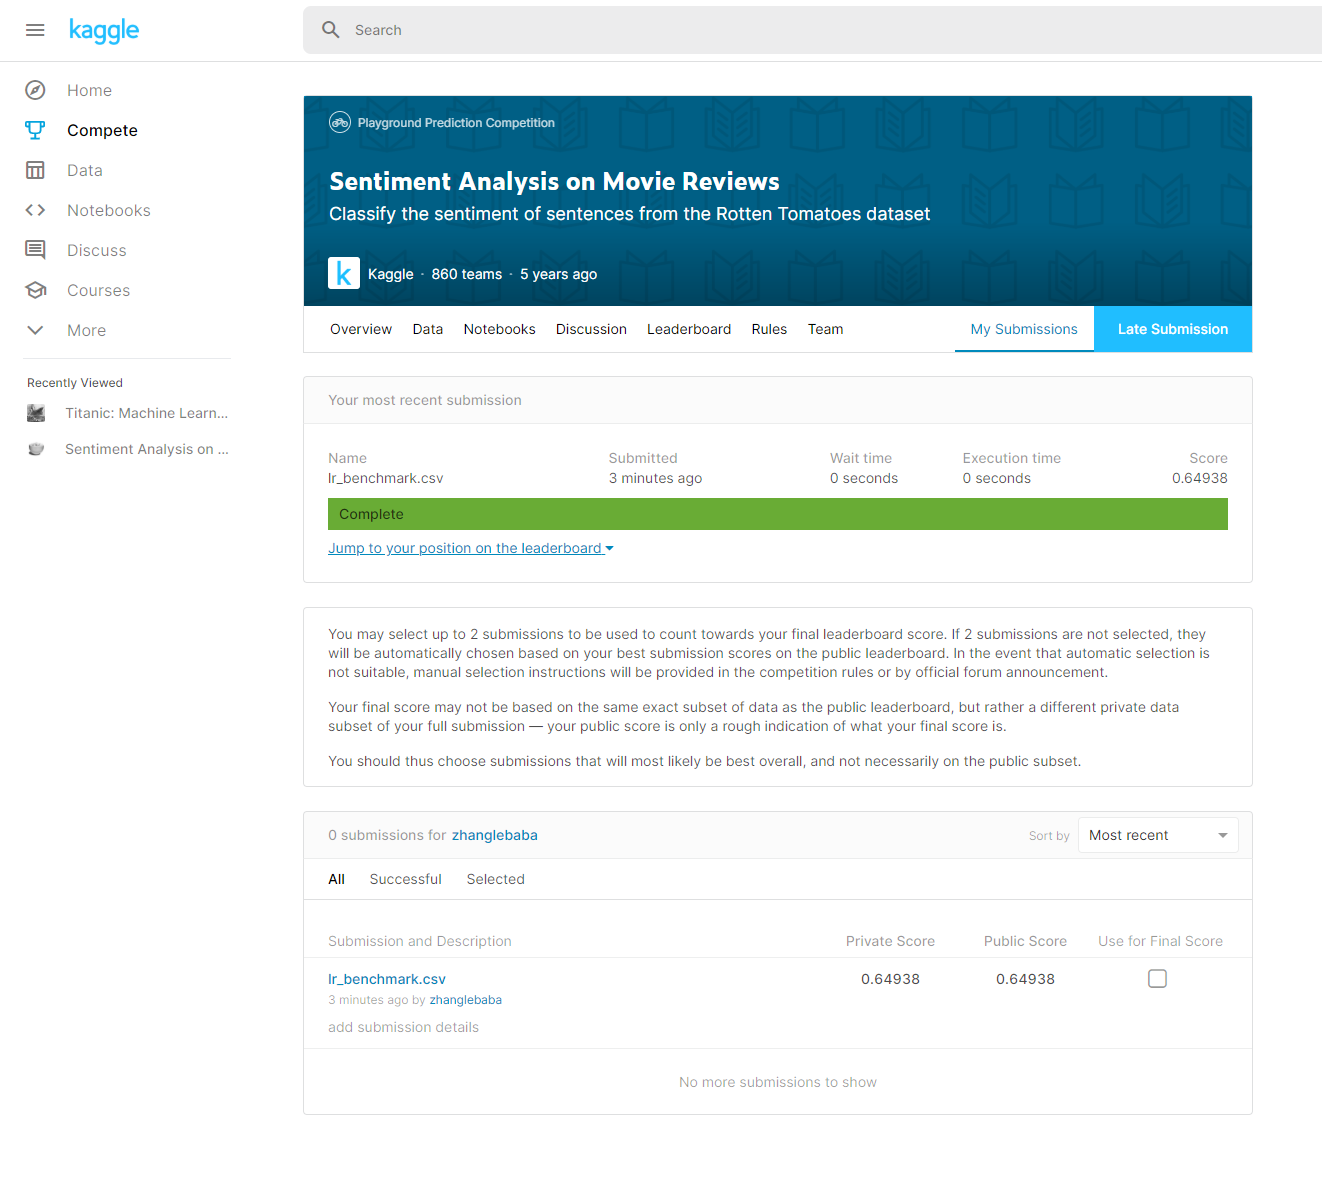

# 2.使用卷积神经网络进行文本分类

### 第一步：数据获取与预处理

这一步与使用循环神经网络完全相同

### 第二步：使用卷积神经网络模型训练并预测

#### 时序最大池化层(Max-over-time pooling)：提取出每个通道最大的数，用于后续在通道维进行连接

In [18]:
class GlobalMaxPool1d(nn.Module):
    def __init__(self):
        super(GlobalMaxPool1d,self).__init__()
    def forward(self,x):
        """
        x:(batch_size,channel,seq_len)
        return:(batch_size,channel,1)
        """
        return F.max_pool1d(x,kernel_size=x.shape[2])

#### 定义模型

In [20]:
class TextCNN(nn.Module):
    def __init__(self,vocab,embed_size,kernel_sizes,num_channels):
        super(TextCNN,self).__init__()
        """依据论文，同时采用pre-train and tast-specific vectors"""
        self.embedding=nn.Embedding(len(vocab),embed_size)
        self.constant_embedding=nn.Embedding(len(vocab),embed_size) #不参与训练的嵌入层
        self.dropout=nn.Dropout(0.5) #在倒数第二层使用，依据论文中dropout rate=0.5
        self.decoder=nn.Linear(sum(num_channels),5) #把所有经过最大池化的在通道维连结，所以长度是输出通道维之和，最后五个分类
        self.pool=GlobalMaxPool1d()
        """论文中的：one feature is extracted by one filter,using multiple filters(with varying windows sizes"""
        self.convs=nn.ModuleList() 
        for c,k in zip(num_channels,kernel_sizes):
            self.convs.append(nn.Conv1d(in_channels=2*embed_size,out_channels=c,kernel_size=k)) #*2因为要讲两个embeddings在词向量维连接起来
    def forward(self,inputs):
        """
        inputs:(batch_size,seq_len)
        embedding:(batch_size,seq_len,2*embed_size)
        """
        embeddings=torch.cat((self.embedding(inputs),self.constant_embedding(inputs)),dim=2)
        #查阅官方文档，卷积层的输入要求是（batch_size,channels,seq_len）
        embeddings=embeddings.permute(0,2,1)
        #对于每一个卷积层，通过时序最大池化后得到的输出是(batch_size,channels,1)，要把最后一维去掉，然后再通道维上连结，得到（batch_size,channels
        encoding=torch.cat([self.pool(F.relu(conv(embeddings))).squeeze(-1)for conv in self.convs],dim=1)
        outputs=self.decoder(self.dropout(encoding))
        return outputs

In [22]:
embed_size,kernel_sizes,nums_channels=100,[3,4,5],[100,100,100] #完全依据原论文设置
net=TextCNN(vocab,embed_size,kernel_sizes,nums_channels)

#### 加载预训练词向量：两个嵌入层都加载glove词向量，然后把一个嵌入层权重固定

In [29]:
glove_vocab=Vocab.GloVe(name='6B',dim=100,cache='E:/data/glove')
net.embedding.weight.data.copy_(load_pretrain_embedding(vocab.itos,glove_vocab))
net.constant_embedding.weight.data.copy_(load_pretrain_embedding(vocab.itos,glove_vocab))
net.constant_embedding.weight.require_grad=False

有1157个 OOV单词.
有1157个 OOV单词.


#### 训练并评价模型：使用与RNN相同的训练函数

In [40]:
lr,num_epochs=0.01,5
optimizer=torch.optim.Adam(filter(lambda p:p.requires_grad,net.parameters()),lr=lr)
loss=nn.CrossEntropyLoss()
train(train_iter,test_iter,net,loss,optimizer,device,num_epochs)

training on  cuda
epoch 1,loss 461.5254, train acc 0.629, test acc0.645 ,time70.0 sec
epoch 2,loss 435.8141, train acc 0.649, test acc0.642 ,time76.3 sec
epoch 3,loss 426.0263, train acc 0.659, test acc0.642 ,time75.5 sec
epoch 4,loss 426.5640, train acc 0.662, test acc0.644 ,time76.8 sec
epoch 5,loss 425.5484, train acc 0.667, test acc0.646 ,time74.3 sec


训练效果较差，准确率没有明显提升，损失函数也并非一直下降，推测是学习率过高的原因，测试lr=0.001效果好很多

#### 测试集输出

In [35]:
def ceshi_predict(data_iter,net,device):
    net=net.to(device)
    print("trianing on",device)
    predict=[]
    i=0
    start=time.time()
    for X in data_iter:
        X=X.to(device)
        y=net(X.view(1,-1)).argmax(dim=1)
        predict.append(y.cpu().item())
        i+=1
        if(i%5000==0):
            print("已预测%d 个样本，剩余% d个样本，花费时间%.3f s"%(i,(ceshi_num-i),time.time()-start))
            start=time.time()
    return predict
ceshi_iter=iter(ceshi_set)
predict_list=ceshi_predict(ceshi_iter,net,device)

trianing on cuda
已预测5000 个样本，剩余 61292个样本，花费时间14.821 s
已预测10000 个样本，剩余 56292个样本，花费时间14.027 s
已预测15000 个样本，剩余 51292个样本，花费时间14.517 s
已预测20000 个样本，剩余 46292个样本，花费时间14.458 s
已预测25000 个样本，剩余 41292个样本，花费时间15.408 s
已预测30000 个样本，剩余 36292个样本，花费时间15.609 s
已预测35000 个样本，剩余 31292个样本，花费时间14.713 s
已预测40000 个样本，剩余 26292个样本，花费时间14.976 s
已预测45000 个样本，剩余 21292个样本，花费时间14.020 s
已预测50000 个样本，剩余 16292个样本，花费时间13.123 s
已预测55000 个样本，剩余 11292个样本，花费时间13.278 s
已预测60000 个样本，剩余 6292个样本，花费时间12.435 s
已预测65000 个样本，剩余 1292个样本，花费时间13.083 s


In [39]:
pred=[[index+156061,x]for index,x in enumerate(predict_list)]
savetxt('E:/data/sentiment-analysis-on-movie-reviews/cnn_benchmark.csv',pred,delimiter=',',fmt='%d,%d',header='PhraseId,Sentiment',comments='')

明显看出来结果不如RNN好，kaggle提交得分也是，但是训练时间和测试时间确实少了不少，可能是添加了dropout层的结果

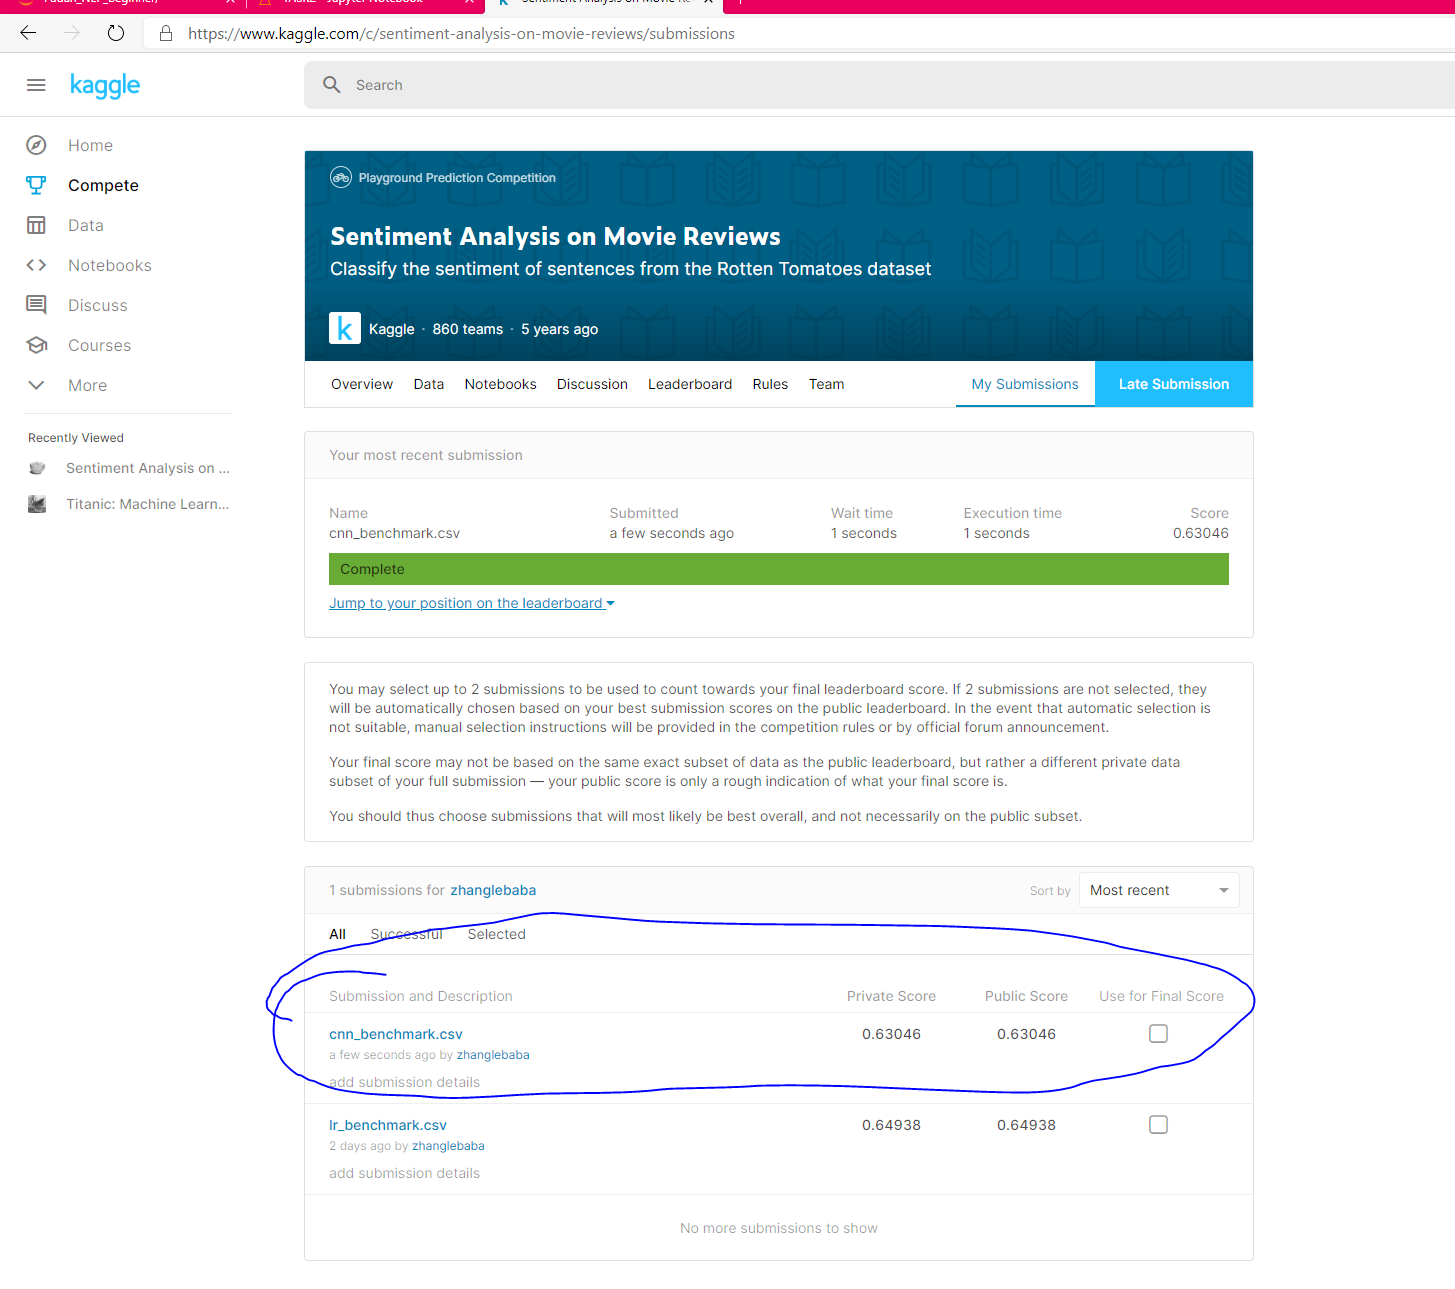